# Predicción del número de trayectos
## Motivación

Este notebook ilustra un ejemplo de predicción del número de trayectos que habrá un día a una hora determinada y pasarán por el parque del Retiro.<br> Tomando como referencia la separación en clusters (GMM) efectuada anteriormente, se quiere tener una idea de cuántos tipos de trayecto (desplazamientos cercanos, desplazamientos lejanos y paseos) habrá.<br>

### Librerías

In [1]:
import numpy as np
import pandas as pd

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn import tree
import pydotplus

#ML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Actualizar path
import os

### Importación y tratamiento previo

Se trabajará con el conjunto de trayectos del mes de agosto y su asignación a los 3 clusters principales que hemos identificado.

In [2]:
#Detalle de los trayectos de agosto con su asignación de clusters
rides=pd.read_json('data/RetiroRidesClustered.json', lines=True,
                   dtype={'zip_code':object, 'orig_to_Retiro':float, 'dest_to_Retiro':float,
                          'retiro_speed':float, 'retiro_rate':float}, convert_dates=['unplug_hourTime'])

In [3]:
#Todo esto no hace falta
rides = rides.drop(columns=['_id', 'ageRange', 'full_track', 'dest_to_Retiro', 'orig_to_Retiro', 'has_multiple_rides',\
                            'idplug_station', 'idunplug_station', 'multiple_rides_cluster_size', 'retiro_rate',\
                            'retiro_track', 'travel_time','user_type','zip_code','gaussian_clusterH'])

In [4]:
#Reordenamos columnas
rides = rides[['unplug_hourTime', 'is_day_off', 'retiro_speed', 'gaussian_cluster']]

In [5]:
#El import/export a JSON no gestiona zona horaria. Nos situamos en huso CET.
rides['unplug_hourTime']=pd.Series(pd.DatetimeIndex(rides['unplug_hourTime']).tz_localize('UTC').tz_convert('CET'))

In [6]:
#Agrupación y conteo por cluster
rides_count = rides[['unplug_hourTime','gaussian_cluster']].groupby(by=['unplug_hourTime','gaussian_cluster'],sort=True)['gaussian_cluster'].count().copy()

In [7]:
#Intervalo completo de días y horas sobre el que queremos trabajar
#Lo usaremos para rellenar el dataframe con las horas donde no hay conteo (horas nocturnas)
interval = pd.date_range('2018-08-01', '2018-08-28 23:00:00', freq='1H', tz='CET')

In [8]:
#Conteo listo
rides_count = rides_count.unstack(['gaussian_cluster']).reindex(interval, index='unplug_hourTime', fill_value=0).fillna(0)
rides_count

gaussian_cluster,0,1,2
2018-08-01 00:00:00+02:00,0.0,0.0,0.0
2018-08-01 01:00:00+02:00,0.0,0.0,0.0
2018-08-01 02:00:00+02:00,0.0,0.0,0.0
2018-08-01 03:00:00+02:00,0.0,0.0,0.0
2018-08-01 04:00:00+02:00,0.0,0.0,0.0
2018-08-01 05:00:00+02:00,0.0,0.0,1.0
2018-08-01 06:00:00+02:00,4.0,0.0,2.0
2018-08-01 07:00:00+02:00,63.0,0.0,11.0
2018-08-01 08:00:00+02:00,102.0,4.0,27.0
2018-08-01 09:00:00+02:00,85.0,5.0,16.0


In [9]:
#Fijamos el índice de fecha para hacer el join siguiente
rides.index = rides.unplug_hourTime

### Modelos

#### Creación de variables

In [10]:
#Nos traemos una variable interesante: si el día no laborable
rides_count = rides_count.join(rides.is_day_off)

In [11]:
#Guardamos la fecha para que el drop_duplicates siguiente no nos machaque todo (en el índice no la toma en cuenta)
rides_count['date']=rides_count.index

In [12]:
#Rellenamos las horas nocturnas de los festivos, que tienen el dato ausente
rides_count = rides_count.drop_duplicates().fillna(method='bfill').drop(['date'], axis=1)

In [13]:
#Renombrado
rides_count.rename({0: 'cluster0', 1: 'cluster1', 2: 'cluster2'}, axis=1, inplace=True)
rides_count.head(3)

,cluster0,cluster1,cluster2,is_day_off
2018-08-01 00:00:00+02:00,0.0,0.0,0.0,False
2018-08-01 01:00:00+02:00,0.0,0.0,0.0,False
2018-08-01 02:00:00+02:00,0.0,0.0,0.0,False


In [14]:
#Vamos a indicar los días de la semana del puente de agosto, pues se nota su incidencia en esa semana
puente_mask = (rides_count.index >= '2018-08-13 00:00:00+02:00') & (rides_count.index <= '2018-08-17 23:00:00+02:00')
rides_count['is_puente']=False
rides_count['is_puente'][puente_mask]=True

C:\Users\vical\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
rides_count['is_puente'].value_counts()

False    552
True     120
Name: is_puente, dtype: int64

In [16]:
#Volvemos al índice entero
rides_count.reset_index(inplace=True)

In [17]:
#Parseamos la hora del día
rides_count['hour'] = pd.Series(map(lambda h : h.strftime('%H'), rides_count['index']))

In [18]:
#Tipos numéricos
rides_count['hour'] = rides_count['hour'].astype('int8')
rides_count['cluster0'] = rides_count['cluster0'].astype('int8')
rides_count['cluster1'] = rides_count['cluster1'].astype('int8')
rides_count['cluster2'] = rides_count['cluster2'].astype('int8')

In [19]:
#Booleanos binarizados
rides_count['is_day_off'] = np.array(rides_count['is_day_off'].values, dtype=int)
rides_count['is_puente'] = np.array(rides_count['is_puente'].values, dtype=int)

In [20]:
#Reordenar
rides_count = rides_count[['index', 'hour', 'is_day_off', 'is_puente', 'cluster0', 'cluster1', 'cluster2']]

In [21]:
#Calculamos el total y lo añadimos, para tenerlo a mano: nuestra primera predicción será sobre el total
rides_count['total'] = rides_count.loc[:,'cluster0':'cluster2'].sum(axis=1)
rides_count

,index,hour,is_day_off,is_puente,cluster0,cluster1,cluster2,total
0,2018-08-01 00:00:00+02:00,0,0,0,0,0,0,0
1,2018-08-01 01:00:00+02:00,1,0,0,0,0,0,0
2,2018-08-01 02:00:00+02:00,2,0,0,0,0,0,0
3,2018-08-01 03:00:00+02:00,3,0,0,0,0,0,0
4,2018-08-01 04:00:00+02:00,4,0,0,0,0,0,0
5,2018-08-01 05:00:00+02:00,5,0,0,0,0,1,1
6,2018-08-01 06:00:00+02:00,6,0,0,4,0,2,6
7,2018-08-01 07:00:00+02:00,7,0,0,63,0,11,74
8,2018-08-01 08:00:00+02:00,8,0,0,102,4,27,133
9,2018-08-01 09:00:00+02:00,9,0,0,85,5,16,106


In [22]:
#No hay nulos
rides_count.isnull().values.any()

False

#### Estudio de la correlación

Se aprecia la fuerte correlación positiva entre el total y los clusters 0 y 2 (desplazamientos más o menos rápidos): son los clusters con mayor número de de trayectos, con diferencia. No obstante no será de utilidad porque éstas son todas variables dependientes que queremos predecir.

También se confirma lo que parece obvio: correlación negativa entre el hecho de **no** ser laborable y el número de trayectos en los clusters 0 y 2 con desplazamientos rápidos, muchísimos menores si no hay que trabajar.<br> Sin embargo el cluster 1 (paseos largos y más o menos tranquilos) apenas se ve afectado: el uso recreativo se mantiene similar.

Por último es reseñable la correlación positiva de **la hora del día** con el conteo, afectada por los trayectos "tranquilos" (cluster 1) que tienen más lugar por la tarde y, sobre todo, por hecho de que las primeras horas del día (de 0 a 5 de la mañana) es uso es prácticamente nulo.

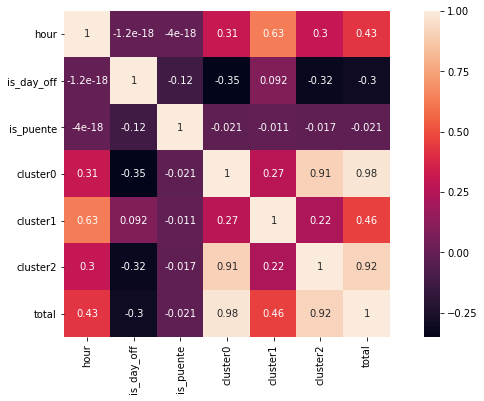

In [23]:
fig,ax= plt.subplots()
fig.set_size_inches(12,6)
sns.heatmap(rides_count.corr(), square=True,annot=True)

C:\Users\vical\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


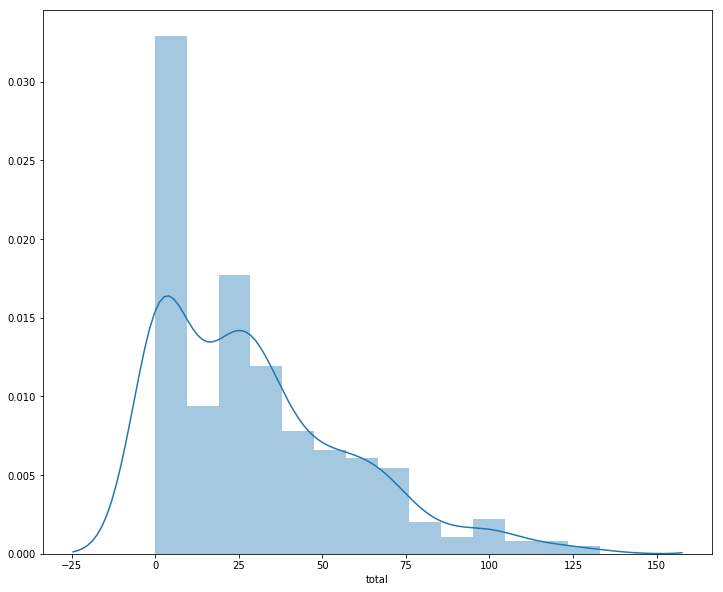

In [24]:
fig,axes = plt.subplots()
fig.set_size_inches(12, 10)
sns.distplot(rides_count['total'])

#### Creación de conjuntos de train y test
Vamos a comenzar prediciendo el total de trayectos directamente

In [25]:
X = rides_count.loc[:, 'hour':'is_puente']
y = rides_count.loc[:, 'cluster0':'cluster2'].sum(axis=1)

In [26]:
X_train = X[:int(len(X)*0.75)]
X_test = X[-int(len(X)*0.25):]

In [27]:
y_train = y[:int(len(X)*0.75)]
y_test = y[-int(len(X)*0.25):]

### 1. Regresión lineal

El modelo de regresión lineal va a arrojar malos resultados principalmente debido a la introducción de la variable **hora** como numérica: es decir, las últimas horas del día tienen valores más elevados y van a condicionar la predicción hacia ahí.
<br>

In [28]:
#Instanciamos y entrenamos
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
#Predicción
y_pred = lr.predict(X_test)

In [30]:
y_pred

array([16.73274725, 18.37734353, 20.0219398 , 21.66653607, 23.31113235,
       24.95572862, 26.60032489, 28.24492117, 29.88951744, 31.53411371,
       33.17870999, 34.82330626, 36.46790253, 38.11249881, 39.75709508,
       41.40169135, 43.04628763, 44.6908839 , 46.33548017, 47.98007645,
       49.62467272, 51.26926899, 52.91386527, 54.55846154, 16.73274725,
       18.37734353, 20.0219398 , 21.66653607, 23.31113235, 24.95572862,
       26.60032489, 28.24492117, 29.88951744, 31.53411371, 33.17870999,
       34.82330626, 36.46790253, 38.11249881, 39.75709508, 41.40169135,
       43.04628763, 44.6908839 , 46.33548017, 47.98007645, 49.62467272,
       51.26926899, 52.91386527, 54.55846154, 16.73274725, 18.37734353,
       20.0219398 , 21.66653607, 23.31113235, 24.95572862, 26.60032489,
       28.24492117, 29.88951744, 31.53411371, 33.17870999, 34.82330626,
       36.46790253, 38.11249881, 39.75709508, 41.40169135, 43.04628763,
       44.6908839 , 46.33548017, 47.98007645, 49.62467272, 51.26

In [31]:
#RMSE
np.sqrt(mean_squared_error(y_test,y_pred))

25.903338047177083

Es un resultado bastante malo. Posibles mejoras para la regresión lineal:
 * Normalizar las variables, sobre todo la **hora**
 * Categorizar esta variable, aunque sea en 3 o 4 franjas horarias, y transformarla en dummies.
 
Vamos a probar otro método.

### 2. Árbol de decisión

Un árbol de decisión debería ir mejor con nuestro caso, porque debería aplicar reglas sobre la hora del día, que condiciona mucho el conteo en cada momento.

Después del entrenamiento de un modelo con todos los parámetros por defecto, obtenemos una sutil mejoría si hallamos la combinación óptima.

_<font color='red'>Ojo</font> tarda 1-2 minutos (lo pongo no ejecutable)_

Se nos propone utilizar una profundidad máxima de **7** niveles, una cantidad mínima de **4** observaciones por hoja y **12** para poder dividir ese nodo.

In [32]:
#Instanciamos y entrenamos con los parámetros propuestos
dt = DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 4, min_samples_split= 12, random_state=86)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           presort=False, random_state=86, splitter='best')

In [33]:
y_pred = dt.predict(X_test)

Para evaluar nuestra regresión calculamos la **raíz del error cuadrático medio (RMSE)**, que expresa un valor en la misma unidad que estamos prediciendo (número de trayectos). Esto da una idea del desvío medio en el número de trayectos predicho cada hora.<br> La mejoría respecto a la regresión lineal es clara.

In [34]:
#RMSE
np.sqrt(mean_squared_error(y_test,y_pred))

9.77881551022528

In [35]:
y_pred

array([1.80000000e+00, 3.00000000e-01, 3.57142857e-02, 3.57142857e-02,
       2.14285714e-01, 8.00000000e-01, 8.30000000e+00, 6.83000000e+01,
       1.15000000e+02, 6.37000000e+01, 2.66190476e+01, 2.66190476e+01,
       2.66190476e+01, 3.21428571e+01, 6.65000000e+01, 8.91428571e+01,
       4.83571429e+01, 4.83571429e+01, 4.83571429e+01, 4.83571429e+01,
       4.83571429e+01, 4.04285714e+01, 2.36000000e+01, 1.78000000e+01,
       1.80000000e+00, 3.00000000e-01, 3.57142857e-02, 3.57142857e-02,
       2.14285714e-01, 8.00000000e-01, 8.30000000e+00, 6.83000000e+01,
       1.15000000e+02, 6.37000000e+01, 2.66190476e+01, 2.66190476e+01,
       2.66190476e+01, 3.21428571e+01, 6.65000000e+01, 8.91428571e+01,
       4.83571429e+01, 4.83571429e+01, 4.83571429e+01, 4.83571429e+01,
       4.83571429e+01, 4.04285714e+01, 2.36000000e+01, 1.78000000e+01,
       1.80000000e+00, 3.00000000e-01, 3.57142857e-02, 3.57142857e-02,
       2.14285714e-01, 8.00000000e-01, 8.30000000e+00, 6.83000000e+01,
      

##### Visualización del árbol
Los nodos oscuros son aquellos con valores más elevados. Se observa perfectamente cómo estos están clasificados a las horas punta del mes de agosto: las **8**h y las **15**h en día laborable.

<b><font color='red'>Atención</font> en Windows</b>, Graphviz debe estar instalado y su ruta en el PATH:

In [36]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

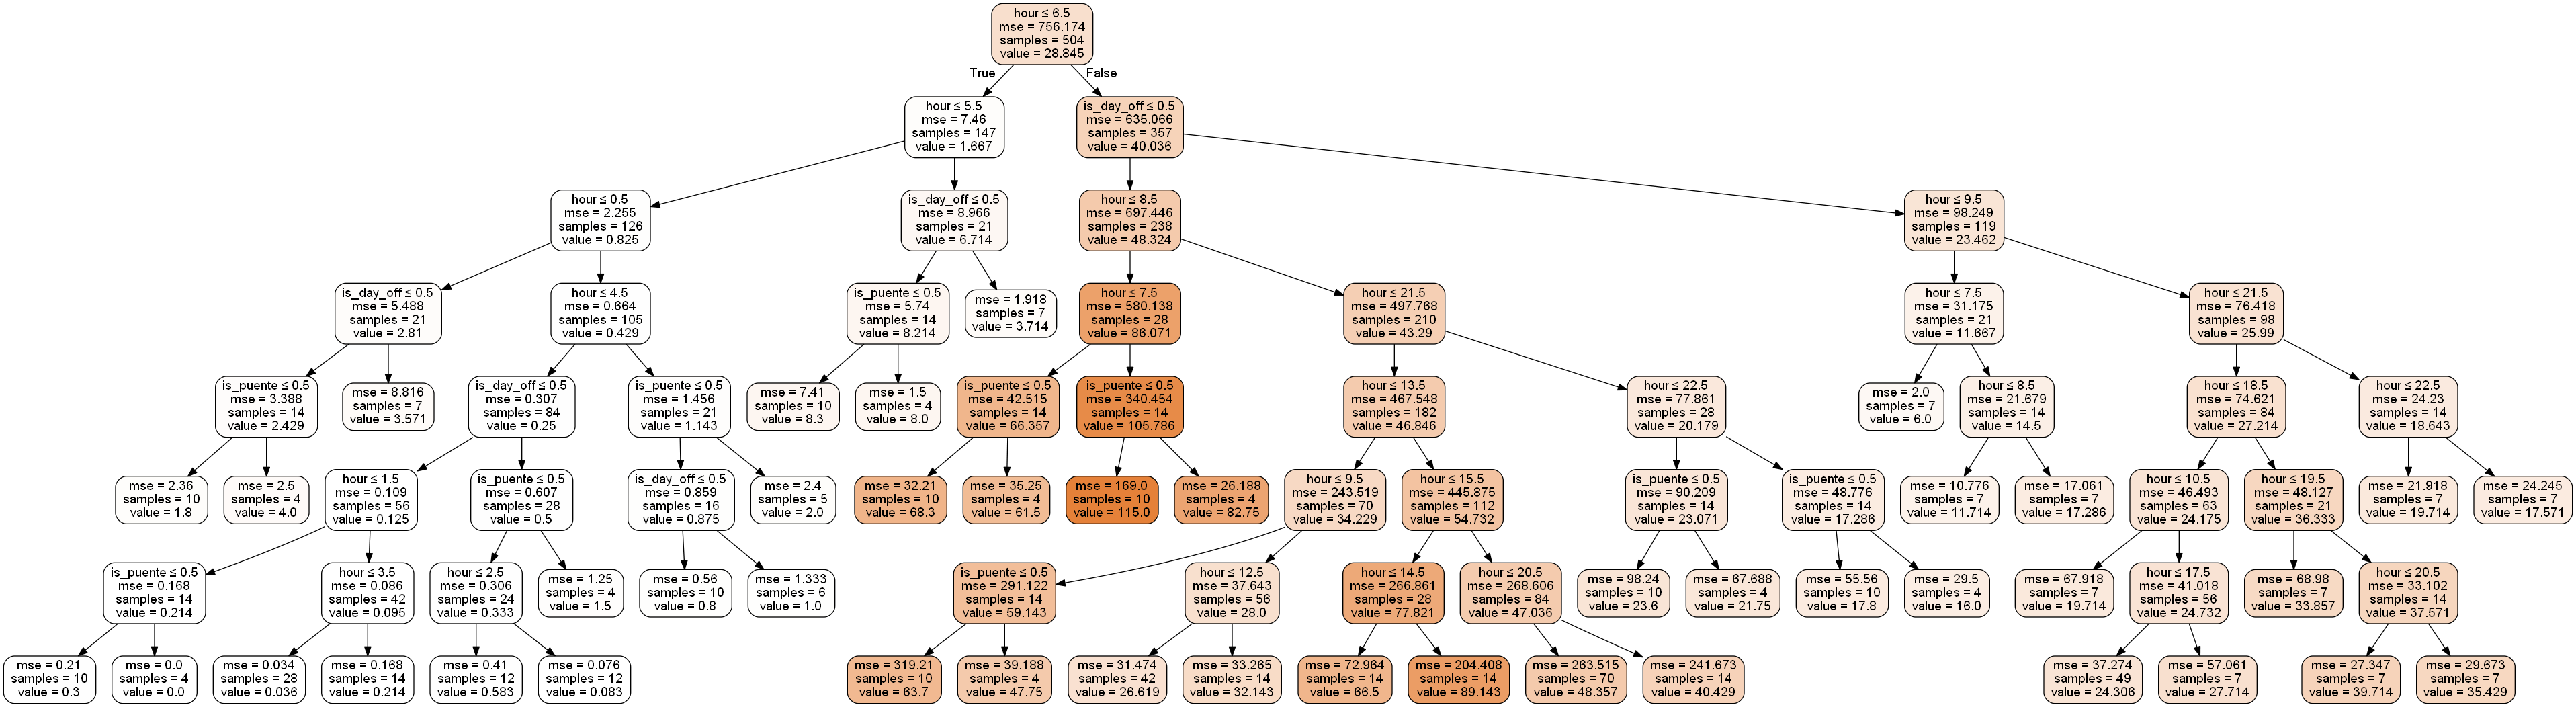

In [37]:
dot_data = tree.export_graphviz(dt, out_file=None, filled=True, rounded=True, special_characters=True,
                                feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png(), width=2000)  

In [38]:
#Preparamos un dataframe del tamaño del conjunto de test para visualizar gráficos luego
rides_test = rides_count.loc[len(X_train):,:].copy()

In [39]:
#Redondeamos la predicción a valores enteros, algo que tiene sentido en el mundo real.
rides_test.loc[:,'y_pred']=y_pred.round().astype('int')

##### Visualización de la predicción del total

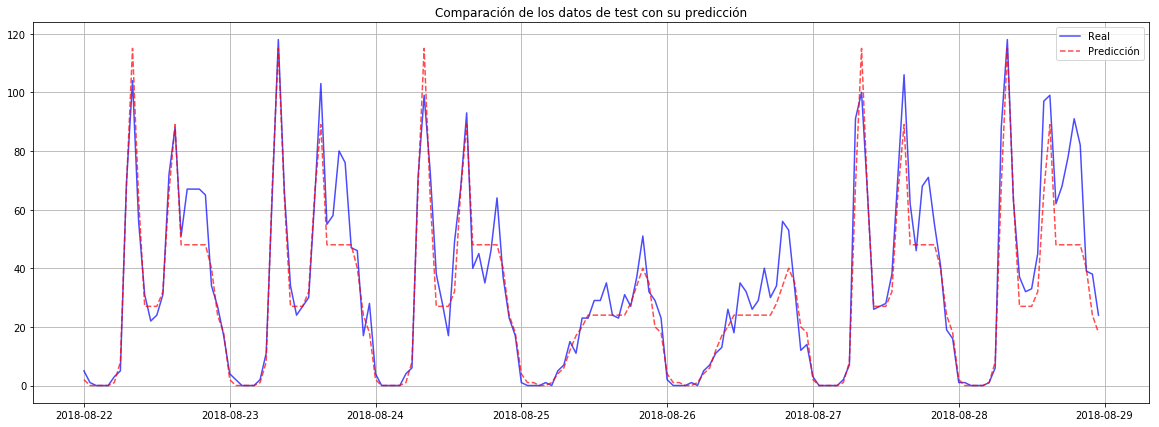

In [40]:
fig, ax = plt.subplots(figsize=(20,7))
ax.grid()
plt.plot(rides_test['index'], rides_test['total'], alpha=.7, color='blue')
plt.plot(rides_test['index'],rides_test['y_pred'], 'r--', alpha=.7)
plt.title("Comparación de los datos de test con su predicción")
plt.legend(labels=['Real','Predicción'])

La predicción tiene buen aspecto en las mañanas pero se ve penalizada por las tardes, seguramente debido a dos factores:
 * Sesgo debido a ruido en los datos de entrenamiento. Por ejemplo el lunes 6 de agosto el parque del Retiro fue cerrado por la tarde por causa de las rachas de viento, por lo que el tráfico durante esa tarde es prácticamente nulo.
 * Falta de predictores que nos permitan conocer las fluctuaciones que ocurren por la tarde (a diferencia de las mañanas, que son muy constantes), por ejemplo:
  * Datos meteorológicos, aunque en el caso de agosto no llovió ni un sólo día y el calor fue generalizado.
  * Eventos cercanos que incrementan el uso.
  * Perturbaciones en la ciudad, incidencias en la estaciones de BiciMAD, etc.

De cara a una predicción más ambiciosa, en el caso de tener datos temporales continuos, convendría enriquecer el set de entrenamiento con ese tipo de datos ambientales también.

### 3. Random Forest

Intentamos afinar más el modelo que nos da el árbol de decisión.

_<font color='red'>Ojo</font> tarda 3 minutos (lo pongo no ejecutable)_

Se nos propone utilizar una profundidad máxima de **8** niveles, una cantidad mínima de **1** observación por hoja (valor por defecto) y **7** para poder dividir ese nodo.

In [41]:
#Instanciamos con los parámetros propuestos
rf=RandomForestRegressor(n_estimators=10, max_depth=8, min_samples_leaf=1, min_samples_split=7, random_state=86)

In [42]:
#Entrenamos
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=86, verbose=0, warm_start=False)

In [43]:
y_pred = rf.predict(X_test)

Mejora levemente al árbol, si bien es cierto que hay una componente aleatoria y no estamos haciendo cross-validation con varias muestras. Nuestro conjunto de datos es bastante pequeño en todo caso

In [44]:
#RMSE
np.sqrt(mean_squared_error(y_test,y_pred))

9.443969219233136

In [45]:
y_pred

array([1.67142857e+00, 2.62884199e-01, 7.35766046e-02, 8.69565217e-03,
       2.77301587e-01, 8.63782051e-01, 8.12900794e+00, 6.69112179e+01,
       1.13666987e+02, 6.33641037e+01, 2.90479987e+01, 2.54751061e+01,
       2.61179802e+01, 3.28992775e+01, 6.82873106e+01, 9.46223676e+01,
       5.02753828e+01, 4.88713141e+01, 4.68917828e+01, 5.19617705e+01,
       4.88141602e+01, 4.39960253e+01, 2.42252579e+01, 1.90019037e+01,
       1.67142857e+00, 2.62884199e-01, 7.35766046e-02, 8.69565217e-03,
       2.77301587e-01, 8.63782051e-01, 8.12900794e+00, 6.69112179e+01,
       1.13666987e+02, 6.33641037e+01, 2.90479987e+01, 2.54751061e+01,
       2.61179802e+01, 3.28992775e+01, 6.82873106e+01, 9.46223676e+01,
       5.02753828e+01, 4.88713141e+01, 4.68917828e+01, 5.19617705e+01,
       4.88141602e+01, 4.39960253e+01, 2.42252579e+01, 1.90019037e+01,
       1.67142857e+00, 2.62884199e-01, 7.35766046e-02, 8.69565217e-03,
       2.77301587e-01, 8.63782051e-01, 8.12900794e+00, 6.69112179e+01,
      

In [46]:
rides_test['y_pred_rf']=y_pred.round().astype('int')

##### Predicción por cluster

La idea ahora es aplicar el mismo modelo RF para predecir el conteo de los 3 clusters por separado

In [47]:
#Ídem -> X = rides_count.loc[:, 'hour':'is_puente']
y0 = rides_count.loc[:, 'cluster0']
y1 = rides_count.loc[:, 'cluster1']
y2 = rides_count.loc[:, 'cluster2']

In [48]:
#Ídem -> X_train = X[:int(len(X)*0.75)]
#Ídem -> X_test = X[-int(len(X)*0.25):]

In [49]:
y_train0 = y0[:int(len(X)*0.75)]
y_test0 = y0[-int(len(X)*0.25):]
y_train1 = y1[:int(len(X)*0.75)]
y_test1 = y1[-int(len(X)*0.25):]
y_train2 = y2[:int(len(X)*0.75)]
y_test2 = y2[-int(len(X)*0.25):]

In [50]:
rf.fit(X_train,y_train0)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=86, verbose=0, warm_start=False)

In [51]:
y_pred0 = rf.predict(X_test)

In [52]:
#RMSE
np.sqrt(mean_squared_error(y_test0,y_pred0))

5.703651739482325

In [53]:
rf.fit(X_train,y_train1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=86, verbose=0, warm_start=False)

In [54]:
y_pred1 = rf.predict(X_test)

In [55]:
#RMSE
np.sqrt(mean_squared_error(y_test1,y_pred1))

4.424934650848973

In [56]:
rf.fit(X_train,y_train2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=7,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=86, verbose=0, warm_start=False)

In [57]:
y_pred2 = rf.predict(X_test)

In [58]:
#RMSE
np.sqrt(mean_squared_error(y_test2,y_pred2))

3.075108326400882

In [59]:
rides_test['y_pred_rf_c0']=y_pred0.round().astype('int')
rides_test['y_pred_rf_c1']=y_pred1.round().astype('int')
rides_test['y_pred_rf_c2']=y_pred2.round().astype('int')

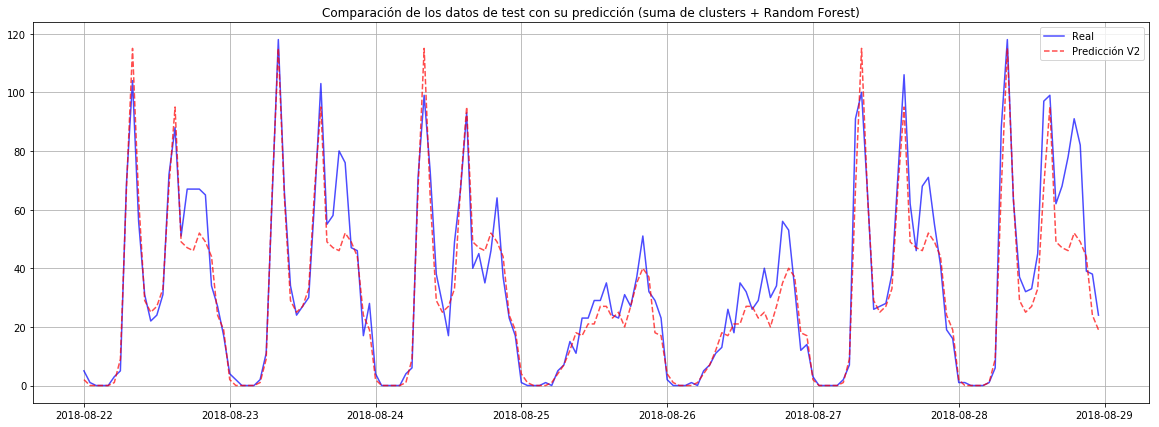

In [60]:
fig, ax = plt.subplots(figsize=(20,7))
ax.grid()
plt.plot(rides_test['index'], rides_test['total'], alpha=.7, color='blue')
plt.plot(rides_test['index'],rides_test['y_pred_rf_c0']+rides_test['y_pred_rf_c1']+rides_test['y_pred_rf_c2'], 'r--', alpha=.7)

plt.title("Comparación de los datos de test con su predicción (suma de clusters + Random Forest)")
plt.legend(labels=['Real','Predicción V2'])

Se puede apreciar que la predicción es más detallada que la del árbol de decisión. Predecir los 3 clusters por separado, cada uno como un random forest dedicado, y sumarlos, da mejores resultados.

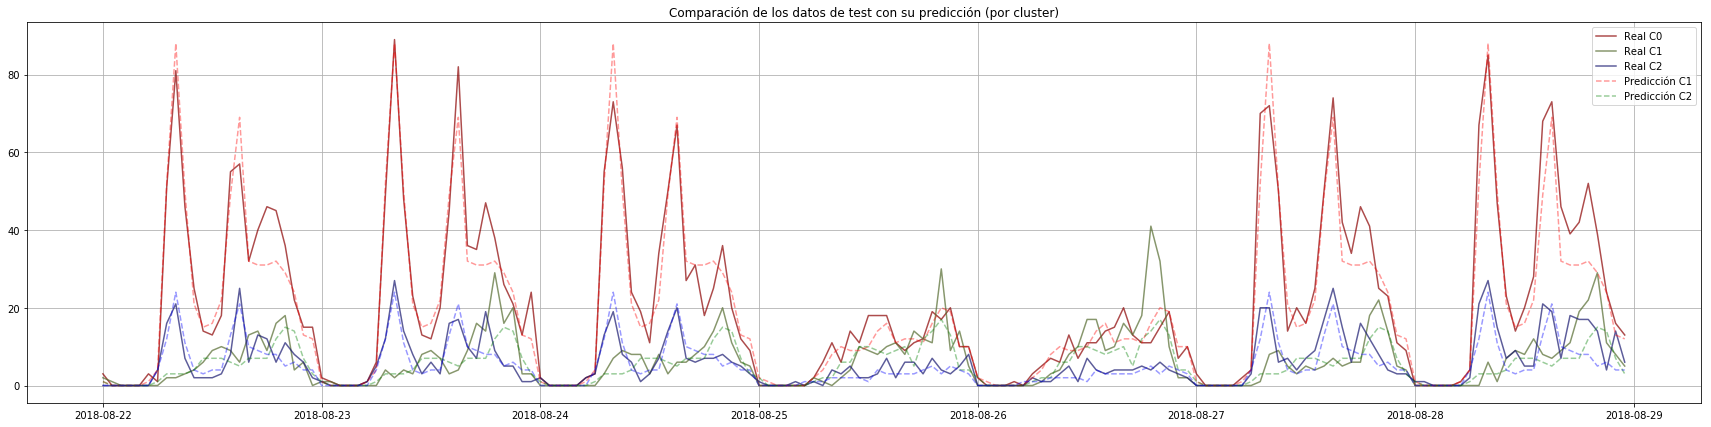

In [61]:
fig, ax = plt.subplots(figsize=(30,7))
ax.grid()
plt.plot(rides_test['index'], rides_test['cluster0'], alpha=.7, color='darkred')
plt.plot(rides_test['index'], rides_test['cluster1'], alpha=.7, color='darkolivegreen')
plt.plot(rides_test['index'], rides_test['cluster2'], alpha=.7, color='midnightblue')
plt.plot(rides_test['index'],rides_test['y_pred_rf_c0'], 'r--', alpha=.4)
plt.plot(rides_test['index'],rides_test['y_pred_rf_c1'], 'g--', alpha=.4)
plt.plot(rides_test['index'],rides_test['y_pred_rf_c2'], 'b--', alpha=.4)

plt.title("Comparación de los datos de test con su predicción (por cluster)")
plt.legend(labels=['Real C0','Real C1','Real C2','Predicción C1','Predicción C2'])

Éste ha sido un ejercicio sencillo para aprovechar los datos de clustering y hacer una predicción con ellos. En este caso hemos entrenado y evaluado sobre los datos del mes de agosto.<br>
Como se ha dicho anteriormente, en caso de tener datos de uso en El Retiro sobre varios meses, tendría sentido aplicar modelos más ambiciosos y cruzar estos datos con otros externos que condicionan la actividad de BiciMAD. De esta forma se podría gestionar mejor la estacionalidad y las situaciones excepcionales (meteorología, etc.) más allá del hecho de ser laborable o no.